# PredNet fine-tuning with IT RDM supervision
In this notebook we fine-tune PredNets pre-trained on video data using RDMs from IT area.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Copying supporting files

In [0]:
!unzip -q gdrive/My\ Drive/algonauts/algonauts-master.zip -d /content/
!unzip -q gdrive/My\ Drive/algonauts/algonauts-dataset.zip -d /content/
!mv algonauts-master/* /content/
!cp Feature_Extract/create_RDMs.py /content/
!cp prednet/*.py /content/
!cp -r gdrive/My\ Drive/algonauts/prednet-models /content/

In [0]:
import h5py
import numpy as np
import scipy.io as sio
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing import image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import os
import glob
import zipfile
from tqdm import tqdm
from data import DataGenerator
np.random.seed(42)

Using TensorFlow backend.


## Methods for loading human fMRI data

In [0]:
def loadmat(matfile):
    try:
        f = h5py.File(matfile)
    except (IOError, OSError):
        return sio.loadmat(matfile)
    else:
        return {name: np.transpose(f.get(name)) for name in f.keys()}

def loadnpy(npyfile):
    return np.load(npyfile)

def load(data_file):
    root, ext = os.path.splitext(data_file)
    return {'.npy': loadnpy,
            '.mat': loadmat
            }.get(ext, loadnpy)(data_file)

human_fmri = loadmat('./Training_Data/118_Image_Set/target_fmri.mat')
human_fmri['EVC_RDMs'].shape

(15, 118, 118)

## Methods for loading image dataset

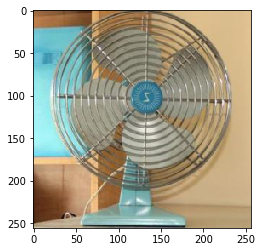

In [0]:
def crop_center(img, cropx, cropy):
    x,y,c = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)   
    return img[startx:startx+cropx,starty:starty+cropy]

def resize_img(img, target_size):
    ratios = [float(target_size[i]) / img.shape[i] for i in range(len(target_size))]
    larger_ratio = max(ratios)
    new_shape = [float(larger_ratio) * img.shape[i] for i in range(len(target_size))]
    
    img = resize(img, (int(np.round(new_shape[0])), 
                       int(np.round(new_shape[1]))),
                 mode='reflect')
    
    # crop
    img = crop_center(img, target_size[0], target_size[1])
    return img

def load_image(filename, target_size=(256, 256)):
    img = image.load_img(filename, target_size=None)
    img = image.img_to_array(img)
    img = 1./255 * img
    img = resize_img(img, target_size=target_size)
    return img

img = load_image('./Training_Data/118_Image_Set/118images/image_118.jpg')
plt.imshow(img)

## Generator for image pairs and corresponding RDM values

In [0]:
def create_rdm_dataset(images_path, rdm_path, data_type):
  rdm_y = []
  rdm_x = []
  
  human_rdm = loadmat(rdm_path)[data_type]
  if 'MEG' in data_type:
    human_rdm = np.mean(human_rdm, 1)
  
  for sub_idx, subject_rdm in enumerate(human_rdm):
      print('Processing subject {} of {} ...'.format(sub_idx+1, len(human_rdm)))

      for img_i in range(subject_rdm.shape[0]):
          for img_j in range(img_i, subject_rdm.shape[1]):
              rdm_y.append(subject_rdm[img_i][img_j])
              img_i_path = images_path.format(img_i+1)
              img_j_path = images_path.format(img_j+1)
              rdm_x.append([img_i_path, img_j_path])

  rdm_y = np.array(rdm_y)
  rdm_x = np.array(rdm_x)

  rdm_shape = human_rdm.shape
  expected_samples = (np.prod(rdm_shape) + rdm_shape[0] * rdm_shape[2]) // 2
  assert rdm_y.shape[0] == expected_samples, (rdm_y.shape[0], expected_samples)
  assert rdm_x.shape[0] == rdm_y.shape[0]
  return rdm_x, rdm_y


def data_generator(data_x, data_y, batch_size=1, n_timesteps=10, 
                   shuffle=True, output_mode=None, image_size=(256, 256)):
    n_batches = len(data_x) // batch_size
    
    while True:
        if shuffle:
            np.random.shuffle(data_x)
            np.random.shuffle(data_y)
        
        for batch_idx in range(n_batches):
            batch_x1 = []
            batch_x2 = []
            batch_y = []
            for idx in range(batch_idx*batch_size, (batch_idx+1)*batch_size):
                batch_x1.append([load_image(data_x[idx][0], target_size=image_size)] * n_timesteps)
                batch_x2.append([load_image(data_x[idx][1], target_size=image_size)] * n_timesteps)
                batch_y.append([data_y[idx]])
                
            batch_x1 = np.array(batch_x1)
            batch_x2 = np.array(batch_x2)
            batch_y = np.array(batch_y)
            
            if output_mode is not None and output_mode == 'representation_and_error':
                batch_y = {
                    'prednet_error': np.zeros(batch_size, np.float32), 
                    'rdm_prediction': batch_y
                }
            yield [batch_x1, batch_x2], batch_y
            
#train_generator = data_generator(train_x, train_y, batch_size=1)
#images, labels = next(train_generator)
#images[0].shape, labels

## Fine-tuning the model using RDMs

In [0]:
from keras.models import Model
from keras.layers import Flatten, Dense, TimeDistributed, LSTM
from keras.layers import Input, Masking, Lambda, Dropout
from keras.layers import Bidirectional, concatenate, average
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras import backend as K

import prednet_model
import prednet_rdm
import utils


def train(config_name, train_x, train_y, val_x, val_y, hidden_dims=[32], 
          epochs=10, use_multiprocessing=False, workers=1, batch_size=1,
          dropout=0.5, stopping_patience=3, base_results_dir='./results',
          input_shape=[10, 256, 256, 3], mask_value=None, all_weights_file=None, 
          data_format=K.image_data_format(), #trainable_layers=None, 
          **config):
    
    train_generator = data_generator(train_x, train_y, batch_size=batch_size, 
                                     output_mode=config['output_mode'])
    val_generator = data_generator(val_x, val_y, batch_size=batch_size, 
                                   output_mode=config['output_mode'])
    
    results_dir = utils.get_create_results_dir(config_name, base_results_dir)
    model = prednet_rdm.create_model(input_shape, hidden_dims, drop_rate=dropout, 
                                     mask_value=mask_value, **config)
    
    if all_weights_file:
        model.load_weights(all_weights_file, by_name=True)
    
    if 'model_json_file' not in config and 'model_weights_file' in config:
        prednet_model.load_prednet_weights(config['model_weights_file'], 
                                           model.get_layer('PredNet'))
    
    checkpoint_path = os.path.join(results_dir, 'weights.hdf5')
    csv_path = os.path.join(results_dir, 'model.log')

    json_file = os.path.join(results_dir, 'model.json')
    json_string = model.to_json()
    with open(json_file, "w") as f:
        f.write(json_string)
    
    checkpointer = ModelCheckpoint(filepath=checkpoint_path, 
                                   #monitor='val_rdm_prediction_loss',
                                   verbose=1, save_best_only=True)
    
    csv_logger = CSVLogger(csv_path)
    stopper_rdm = EarlyStopping(monitor='val_rdm_prediction_loss', 
                                patience=stopping_patience, 
                                verbose=0, mode='auto')
    
    model.fit_generator(train_generator,
                        len(train_x),
                        epochs=epochs,
                        validation_data=val_generator,
                        validation_steps=len(val_x),
                        callbacks=[checkpointer, csv_logger, stopper_rdm],
                        use_multiprocessing=use_multiprocessing,
                        workers=workers)
    
    model.save(os.path.join(results_dir, 'model.h5'))
    weights_path = os.path.join(results_dir, 'prednet_weights.h5')
    model.get_layer('PredNet').save_weights(weights_path)
    model_json = model.get_layer('PredNet').to_json()
    json_path = os.path.join(results_dir, 'prednet_model.json')
    with open(json_path, 'w') as json_file:
        json_file.write(model_json)

## Fine-tuning PredNet using fMRI RDMs

In [0]:
config = {
    'n_timesteps': 10,
    'batch_size': 1,
    'stateful': False,
    'input_width': 256,
    'input_height': 256,
    'input_channels': 3,
    'stack_sizes': (48, 96, 192, 192),
    'rescale': 1./255,
    'shuffle': True,
    'workers': 1,
    'epochs': 1,
    'train': True,
    'freeze_prednet': False,
    'output_mode': 'representation_and_error',
    'prediction_error_weight': 0.9,
    'rdm_error_weight': 0.1,
    #'trainable_layers': [0, 1, 2], # list of PredNet trainable layers
    #'trainable_units': ['a', 'ahat'], #['i', 'f', 'c', 'o'],
    'model_json_file': '/content/prednet-models/prednet_moments__model__4_layers_epoch_1/model.json', 
    'model_weights_file': '/content/prednet-models/prednet_moments__model__4_layers_epoch_1/weights.hdf5',
    'base_results_dir': '/content/results/',
}

images_path = '/content/Training_Data/118_Image_Set/118images/image_{:03d}.jpg'
rdm_path = '/content/Training_Data/118_Image_Set/target_fmri.mat'

In [0]:
rdm_path = '/content/Training_Data/118_Image_Set/target_fmri.mat'
it_x, it_y = create_rdm_dataset(images_path, rdm_path, 'IT_RDMs')
train_x, val_x, train_y, val_y = train_test_split(it_x, it_y, test_size=0.1, 
                                                  random_state=17)

idx = np.random.randint(len(train_x), size=10000)
sample_train_x = train_x[idx]
sample_train_y = train_y[idx]

idx = np.random.randint(len(val_x), size=len(sample_train_x)//10)
sample_val_x = val_x[idx]
sample_val_y = val_y[idx]

train('prednet_moments_fmri_it_rdm_10000', sample_train_x, sample_train_y, 
      sample_val_x, sample_val_y, **config)

Processing subject 1 of 15 ...
Processing subject 2 of 15 ...
Processing subject 3 of 15 ...
Processing subject 4 of 15 ...
Processing subject 5 of 15 ...
Processing subject 6 of 15 ...
Processing subject 7 of 15 ...
Processing subject 8 of 15 ...
Processing subject 9 of 15 ...
Processing subject 10 of 15 ...
Processing subject 11 of 15 ...
Processing subject 12 of 15 ...
Processing subject 13 of 15 ...
Processing subject 14 of 15 ...
Processing subject 15 of 15 ...
Loading model: /content/prednet-models/prednet_moments__model__4_layers_epoch_1/weights.hdf5
PredNet trainable layers: None
PredNet trainable units: None
Layer a_0 trainable params: 2640
Layer a_1 trainable params: 83040
Layer a_2 trainable params: 331968
Layer a_3 trainable params: 663744
Layer ahat_0 trainable params: 84
Layer ahat_1 trainable params: 20784
Layer ahat_2 trainable params: 83040
Layer ahat_3 trainable params: 331968
Layer ahat_4 trainable params: 331968
Layer c_0 trainable params: 1542
Layer c_1 trainable p

In [0]:
!cp -r ./results gdrive/My\ Drive/prednet-finetuned-models-$(date +%Y-%m-%dT%H:%M:%S)

## Fine-tuning PredNet using MEG RDMs
This does not seem to work well....

In [0]:
rdm_path = '/content/Training_Data/118_Image_Set/target_meg.mat'
meg_x, meg_y = create_rdm_dataset(images_path, rdm_path, 'MEG_RDMs_late')
train_x, val_x, train_y, val_y = train_test_split(meg_x, meg_y, test_size=0.1, 
                                                  random_state=17)

idx = np.random.randint(len(train_x), size=10000)
sample_train_x = train_x[idx]
sample_train_y = train_y[idx]

idx = np.random.randint(len(val_x), size=len(sample_train_x)//10)
sample_val_x = val_x[idx]
sample_val_y = val_y[idx]

train('prednet_moments_meg_late_rdm_10000', sample_train_x, sample_train_y, 
      sample_val_x, sample_val_y, **config)

Processing subject 1 of 15 ...
Processing subject 2 of 15 ...
Processing subject 3 of 15 ...
Processing subject 4 of 15 ...
Processing subject 5 of 15 ...
Processing subject 6 of 15 ...
Processing subject 7 of 15 ...
Processing subject 8 of 15 ...
Processing subject 9 of 15 ...
Processing subject 10 of 15 ...
Processing subject 11 of 15 ...
Processing subject 12 of 15 ...
Processing subject 13 of 15 ...
Processing subject 14 of 15 ...
Processing subject 15 of 15 ...
Loading model: /content/prednet-models/prednet_moments__model__4_layers_epoch_1/weights.hdf5
PredNet trainable layers: None
PredNet trainable units: None
Layer a_0 trainable params: 2640
Layer a_1 trainable params: 83040
Layer a_2 trainable params: 331968
Layer a_3 trainable params: 663744
Layer ahat_0 trainable params: 84
Layer ahat_1 trainable params: 20784
Layer ahat_2 trainable params: 83040
Layer ahat_3 trainable params: 331968
Layer ahat_4 trainable params: 331968
Layer c_0 trainable params: 1542
Layer c_1 trainable p

In [0]:
!cp -r ./results gdrive/My\ Drive/prednet-finetuned-models-$(date +%Y-%m-%dT%H:%M:%S)